# Data Preprocessing

In [1]:
import pandas as pd
import stumpy
import numpy as np

import time # just for dev purpose
from IPython.display import display # Just for displaying DF nicely

from itertools import product

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

from util.util import *

### Reading only one file

Agostinelli Logs (run this or Sparkasse Example)

In [2]:
# Validation Logs
csvPath = "logs/smartRPA/"

filename = "2020-11-07_17-28-29__250_25_40_3.csv"
#filename = "2020-11-07_17-41-57__1000_100_80_4.csv"
#filename = "2020-11-07_21-09-26__750_100_80_5.csv"
#filename = "2020-11-17_15-05-40__500_100_40_4.csv"

filenamesList = ["2020-11-17_15-05-40__500_100_40_4.csv","2020-11-07_21-09-26__750_100_80_5.csv",
                 "2020-11-07_17-41-57__1000_100_80_4.csv","2020-11-07_17-28-29__250_25_40_3.csv"]

df = pd.read_csv(csvPath + filename, encoding = "latin-1")

Sparkasse 1h Recording Sample by Tom (run this or Agostinelli Logs)

In [41]:
# Sparkasse 1h test log
csvPath = "logs/Banking/"

filename = "TSMD Log Sparkass_combined.csv"
df = pd.read_csv(csvPath + filename, encoding = "latin-1")
df

,ï»¿case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_relevance,event_src_path,...,tag_value,tag_checked,tag_html,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full,screenshot
0,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:35:06.288,tomho,Browser,Edge,newTab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:35:06.305,tomho,Browser,Edge,selectTab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:35:11.941,tomho,Browser,Edge,generated,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:35:13.859,tomho,Browser,Edge,clickLink,NaN,NaN,...,NaN,NaN,"<h2 data-test-id=""result-title"" class=""result-...",https://www.sparkasse-karlsruhe.de/de/home/log...,Demo Online-Banking chipTAN - Sparkasse Karlsruhe,NaN,"{'data-test-id': 'result-link', 'href': 'https...","id(""main"")/div[1]/section[1]/div[2]/div[2]/art...",/HTML[1]/BODY[1]/DIV[1]/DIV[1]/DIV[1]/MAIN[1]/...,NaN
4,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:35:14.276,tomho,Browser,Edge,link,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,309093506288000,SmartRPA by marco2012,complete,2024-03-09T10:20:04.374,tomho,Browser,Edge,link,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,309093506288000,SmartRPA by marco2012,complete,2024-03-09T10:20:06.535,tomho,Browser,Edge,clickButton,NaN,NaN,...,NaN,NaN,"<span class=""time-used"" style=""width: 0%;""></s...",NaN,Abmelden,NaN,{'parentNodeTitle': ''},/html[1]/body[1]/div[2]/div[1]/div[1]/div[3]/f...,/HTML[1]/BODY[1]/DIV[2]/DIV[1]/DIV[1]/DIV[3]/F...,NaN
392,309093506288000,SmartRPA by marco2012,complete,2024-03-09T10:20:06.536,tomho,Browser,Edge,submit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/html[1]/body[1]/div[2]/div[1]/div[1]/div[3]/f...,/HTML[1]/BODY[1]/DIV[2]/DIV[1]/DIV[1]/DIV[3]/F...,NaN
393,309093506288000,SmartRPA by marco2012,complete,2024-03-09T10:20:06.906,tomho,Browser,Edge,formSubmit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating a mix DF from multiple files

This process creates a DF using cases from different files that are within the filenameList.

For each file
- Select 5 unique case ids
- Get all events per case
- Append these events to the mixed_df

Result: (5 * Number of Files) Cases in a new DF

In [3]:
# Create a df containing cases from different Agostinelli logs to vary patterns
mixed_df = pd.DataFrame() 
for file in filenamesList:
    df = pd.read_csv(csvPath + file)
    # Get the first 5 unique case:concept:name values
    unique_cases = df['case:concept:name'].unique()[:5]
    
    # Filter the DataFrame to keep only rows with those unique values
    df_filtered = df[df['case:concept:name'].isin(unique_cases)]
    concat_dfs = [mixed_df,df_filtered]
    mixed_df = pd.concat(concat_dfs,ignore_index=True)

df = mixed_df
#df

### Creating a validation data set from available logs

Objective: Create a dataframe that mimics a long time recording of users, which contains routines

Method:
  1. Get user interactions (a) and create a set of user actions (A)
  2. Select random actions (1-n consequtive per looping) append them into a dataframe (D) until a upper limit (x) is reached
        - The upper limit x is considered as 1 action per 3 seconds in a 8 hour work day => 8* 60 * (60/3) = 9600 actions a day
  4. Get routines (r) (1-m overall) and insert the routines (r) o-times at random points into the dataframe (D)
        - The routines need not interrupt themselfs, otherwise no motif could be discovered (for future tests, the could interrupt as well)

Result: A dataframe (D) with x + (o * len(r)) number of actions containing m routines at random points

In [ ]:
start_time = time.time()
# ---- 1 Get user interactions ----
df = read_csvs_and_combine(csvPath)
# Drop duplicates based on equality assumption in https://doi.org/10.1016/j.compind.2022.103721                                                                                     
subset=["category","application","concept:name","event_src_path","event_dest_path","browser_url","xpath"]
df = df.drop_duplicates(subset=subset)
print(f"There are {len(df)} unique events in the dataframe")

time2 = time.time()
print(f"Row creation took {time2-start_time} \n")

# ---- 2 Create shuffled UI log ----
uiLog = get_rand_uiLog(df)

time3 = time.time()
print(f"UiLog creation took {time3-time2} \n")

# ---- 3 Add routines in the dataframe ----
column_name = 'case:concept:name'
m = 1
o = 3
random_list = get_random_values(df, column_name, m, 15)

routine = df[df[column_name] == random_list[0]]
modified_df, indices = insert_rows_at_random(uiLog, routine, o, shuffled=False, reduced=False, reduced_by=20)

# ---- 4 Outputting stuff ----
end_time = time.time()
print(f"Random case insertion took {end_time-time3} \n")
print(random_list)
print(indices)

In [ ]:
df = modified_df
df[df["case:concept:name"]==random_list[0]]

# Adding Boundary Information 
Utilizing the method proposed by Rebmann and van der Aa (https://link.springer.com/chapter/10.1007/978-3-031-34560-9_9) in https://github.com/a-rebmann/task-recognition

In [42]:
from util.uipatternminer import UIPatternMiner
from util.const import path_to_files, log_dir, value_attributes, semantic_attributes, context_attributes, MICROTASK, CASEID, USERACTIONID, case_ids, timeStamps

# 2. Get Micro Tasks by creating uipatternminer Class Object
context_atts = context_attributes
value_atts = value_attributes
semantic_atts = semantic_attributes

for file in filenamesList:
    case_ids = {file: "case:concept:name"}
    timeStamps = {file: "time:timestamp"}

miner = UIPatternMiner(df, case_ids, timeStamps, context_atts, value_atts, semantic_atts)
miner.get_micro_tasks()
boundary_indices = miner.get_attribute("boundaries")

# Add column with boundaries to df
df[MICROTASK] = ''
for index in boundary_indices:
    df.at[index, MICROTASK] = 'True'

# Include calculate_time_difference 
# Adding a weekly average as seperator (gap attribute) might be a solution to get better "segmenetation" of task switches as described in doi.org/10.1145/2063576.2063947
df = calculate_time_difference(df, miner.timeStamp, gap=300, n_rolling=10)

# Merge case boundary col, time Difference Boundary, and micro task boundary col in isBoundaryCol
df['isBoundary'] = df.apply(lambda row: row[MICROTASK] == 'True' or row['timeDifferenceBoolStatic'] == True or row['timeDifferenceBoolRolling'] == True, axis=1)

df[[MICROTASK,"timeDifferenceBoolStatic","timeDifferenceBoolRolling",'isBoundary','timeDifference',"n-running-difference"]]

ValueError: No case id column found for provided case identifiers in the provided dataframe.

In [40]:
result = df.groupby('isBoundary')['isBoundary'].value_counts()
print(result)

print(len(df))

KeyError: 'isBoundary'

### Getting the tuple data ready
#### Agostinelli Log

In [43]:
conceptNames = {
    'beforeSaveWorkbook','urlHashChange','contextMenu','clickCheckboxButton','clickRadioButton','navigateTo','link','typed','form','reload','clickTextField',
    'clickButton','clickLink','selectOptions','selectText','submit','changeField','doubleClick','dragElement','cancelDialog','fullscreen','attachTab',
    'detachTab','newBookmark','removeBookmark','modifyBookmark','moveBookmark','startDownload','erasedDownload','installBrowserExtension','uninstallBrowserExtension',
    'enableBrowserExtension','disableBrowserExtension','closedNotification','clickedNotification','newWindow','closeWindow','newTab','closeTab','moveTab',
    'mutedTab','unmutedTab','pinnedTab','unpinnedTab','audibleTab','zoomTab','changeHistory','created','modified','deleted','Mount','Unmount','moved',
    'programOpen','programClose','selectFile','selectFolder','hotkey','insertUSB','printSubmitted','openFile','openFolder','copy','paste','cut','openWindow','closeWindow',
    'resizeWindow','newWorkbook','openWorkbook','addWorksheet','saveWorkbook','printWorkbook','closeWorkbook','activateWorkbook','deactivateWorkbook','modelChangeWorkbook',
    'newChartWorkbook','afterCalculate','selectWorksheet','deleteWorksheet','doubleClickCellWithValue','doubleClickEmptyCell','rightClickCellWithValue',
    'rightClickEmptyCell','sheetCalculate','editCellSheet','deselectWorksheet','followHiperlinkSheet','pivotTableValueChangeSheet','getRange',
    'getCell','worksheetTableUpdated','addinInstalledWorkbook','addinUninstalledWorkbook','XMLImportWorkbook','XMLExportWorkbook','activateWindow',
    'deactivateWindow','doubleClickWindow','rightClickWindow','newDocument','openDocument','changeDocument','saveDocument','printDocument','activateWindow',
    'deactivateWindow','rightClickPresentation','doubleClickPresentation','newPresentation','newPresentationSlide','closePresentation','savePresentation',
    'openPresentation','printPresentation','slideshowBegin','nextSlideshow','clickNextSlideshow','previousSlideshow','slideshowEnd','SlideSelectionChanged',
    'startupOutlook','quitOutlook','receiveMail','sendMail','logonComplete','newReminder'
    }

# Update dict creation to sort the data before to create meaningful dicts -> Equal applications are grouped together for example
conceptNamesDict = createDict(conceptNames)
conceptNamesDict = createDict(set(df.sort_values(by=['concept:name'])['concept:name'].unique()))
# applicationDict = createDict(set(df.sort_values(by=['application'])['application'].unique()))
applicationDict = createDict(set(df['application'].unique()))
categoriesDict = createDict(set(df.sort_values(by=['category'])['category'].unique()))

print(f"The number of concept names is {len(conceptNamesDict)}, of applications is {len(applicationDict)}, and categories is {len(categoriesDict)}")

# Add new columns with IDs (corrected call to apply)
# Agostinelli Data
df['concept:name:id'] = df.apply(lambda row: get_key(row, conceptNamesDict, 'concept:name'), axis=1)
df['application:id'] = df.apply(lambda row: get_key(row, applicationDict, 'application'), axis=1)
df['category:id'] = df.apply(lambda row: get_key(row, categoriesDict, 'category'), axis=1)

# Print the updated DataFrame
# For Agostinelli Data
print(df[["time:timestamp",'concept:name', 'application', 'category', 'concept:name:id', 'application:id', 'category:id']])

The number of concept names is 26, of applications is 31, and categories is 4
              time:timestamp concept:name application          category  \
0    2024-03-09T09:35:06.288       newTab        Edge           Browser   
1    2024-03-09T09:35:06.305    selectTab        Edge           Browser   
2    2024-03-09T09:35:11.941    generated        Edge           Browser   
3    2024-03-09T09:35:13.859    clickLink        Edge           Browser   
4    2024-03-09T09:35:14.276         link        Edge           Browser   
..                       ...          ...         ...               ...   
390  2024-03-09T10:20:04.374         link        Edge           Browser   
391  2024-03-09T10:20:06.535  clickButton        Edge           Browser   
392  2024-03-09T10:20:06.536       submit        Edge           Browser   
393  2024-03-09T10:20:06.906   formSubmit        Edge           Browser   
394                       UT          NaN         NaN  ynUShuEBwiZqaVvf   

     concept:name:id 

Make the multi dimensional Agostinelli log one dimensional using another tuple generator

Using the ideas ('concept:name:id','application:id', 'category:id') generated earlier in the process based on the dictonaries 

In [44]:
numbersDF = df[['concept:name:id', 'application:id', 'category:id']]

# Generate unique tuples for indexing the individual combinations of the rows mentioned
unique_df = numbersDF.drop_duplicates(subset=numbersDF.columns, keep='first')
tuples = [tuple(row[['concept:name:id', 'application:id', 'category:id']]) for i, row in unique_df.sort_values(by='application:id').iterrows()]
       

df['id'] = df.apply(lambda row: get_id(row, tuples, columns=['concept:name:id','application:id', 'category:id']), axis=1)
# Print the updated DataFrame
print(df['id'])

0      74
1      56
2      57
3      58
4      59
       ..
390    59
391    71
392    67
393    68
394    54
Name: id, Length: 395, dtype: int64


### Save DF after processing for temporary analysis

In [12]:
filepath = "logs/your_data.csv"
df.to_csv(filepath, index=False)

### Display different ordering clusters
Timeseries data is continuous and thus the process mining data has to be transformed in a way that it does represent a continuous spectrum of values.

We test the following approaches to create the timeseries integer values for a continuous spectrum:
- Tuple ID by occurance: The first occurance gets ID=1, the second ID=2, and so on. This leads to a spectrum based on value occurance
- Tuple ID by application: Similar applications should get similar tuple IDs. Thus, we define a list of applications that can occurr in the log and order the applications by similarity. E.g. Firefox and Chrome have closer tuple values compared to Firefox and Outlook.
- Tuple ID by action: Similar actions get similar IDs. Thus, we cluster the actions based on their generic type. We suggest the clustering based on:
    - mouse interactions, keyboard interactions, and other interactions.
    - the generic action types "Open" "Close" "Navigate" "Transform" "Transfer" "Empty" "Conclude"

Based on the sorting we check the quality of the data distribution by the mean difference between the tuple IDs in the log.
I.e. we calculate the difference between all occurring values in the log and take the mechanism creating the smallest average difference between consequitive occurances.

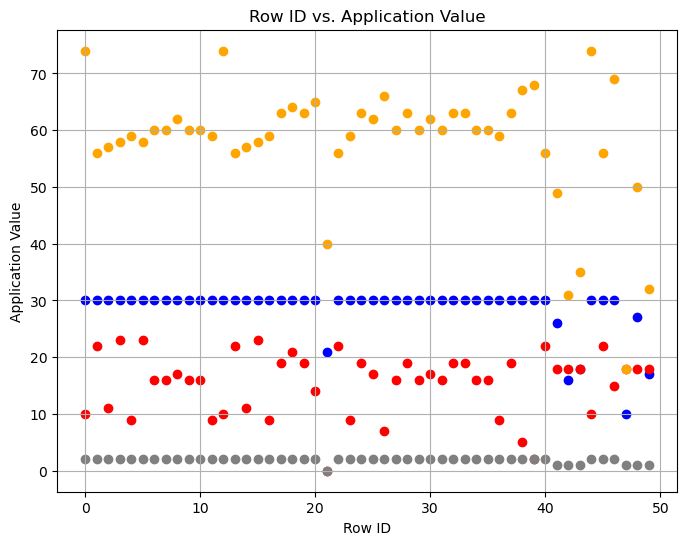

In [45]:
first_50_rows = df.iloc[:50]

# Get row IDs (index starts from 0)
row_ids = first_50_rows.index

# Extract application values
application_values = first_50_rows['application:id'].to_numpy()  # Convert to NumPy array for efficiency
concept_names = first_50_rows['concept:name:id'].to_numpy()  
categories_values = first_50_rows['category:id'].to_numpy()  
tuple_ids = first_50_rows['id'].to_numpy() 

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(row_ids, application_values, color='blue')
plt.scatter(row_ids, concept_names, color='red')
plt.scatter(row_ids, categories_values, color='grey')
plt.scatter(row_ids, tuple_ids, color='orange')
plt.xlabel('Row ID')
plt.ylabel('Application Value')
plt.title('Row ID vs. Application Value')
plt.grid(True)
plt.show()

In [22]:
# Calculate differences between consecutive values (avoid first element)
differences_app = df['application:id'].diff(periods=-1)  # Avoids unnecessary row iteration
differences_app.iloc[0] = pd.NA  # Set difference for the first row to not-a-number (optional)

differences_concept = df['concept:name:id'].diff(periods=-1) 
differences_concept.iloc[0] = pd.NA  

differences_cat = df['category:id'].diff(periods=-1)  
differences_cat.iloc[0] = pd.NA  

differences_tuple = df['id'].diff(periods=-1)  
differences_tuple.iloc[0] = pd.NA

# Calculate the mean of absolute differences (mean jump)
mean_jump_app = differences_app.abs().mean()
mean_jump_conceptname = differences_concept.abs().mean()
mean_jump_cat = differences_cat.abs().mean()
mean_jump_tup = differences_tuple.abs().mean()

print("Mean alteration rate between consecutive application:id values:", mean_jump_app) # Best score so far when just taking apps as they come at 1.8
print("Mean alteration rate between consecutive concept:name:id values:", mean_jump_conceptname) # best score if only concepts are considered that appear in the df at 12.6 (if all actions are considered ~36)
print("Mean alteration rate between consecutive category:id values:", mean_jump_cat) 
print("Mean alteration rate between consecutive tuple id values:", mean_jump_tup) # score does not change a lot, best score around 9.3/9.4

Mean alteration rate between consecutive application:id values: 2.0585787451984636
Mean alteration rate between consecutive concept:name:id values: 14.20326504481434
Mean alteration rate between consecutive category:id values: 0.31994238156209986
Mean alteration rate between consecutive tuple id values: 9.723911651728553


Modelling the data in a 3D space

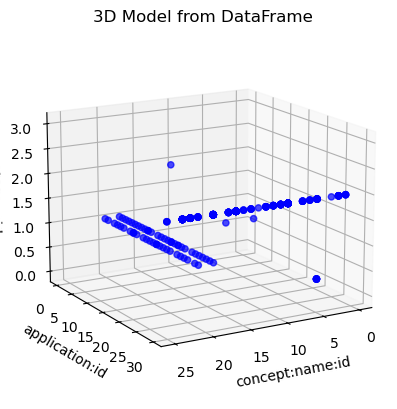

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract data from each column
x = df['concept:name:id']
y = df['application:id']
z = df['category:id']

# Plot the points
ax.scatter(x, y, z, c='blue', alpha=0.7)

# Set labels and title
ax.set_xlabel('concept:name:id')
ax.set_ylabel('application:id')
ax.set_zlabel('category:id')
ax.set_title('3D Model from DataFrame')

# Adjust view angles (optional)
ax.view_init(elev=15, azim=60)

# Show the plot
plt.show()

## Motife Discovery

From Time https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-a-Motif-Using-STUMP:

Time series motifs are approximately repeated subsequences found within a longer time series. Being able to say that a subsequence is “approximately repeated” requires that you be able to compare subsequences to each other. In the case of STUMPY, all subsequences within a time series can be compared by computing the pairwise z-normalized Euclidean distances and then storing only the index to its nearest neighbor. This nearest neighbor distance vector is referred to as the matrix profile and the index to each nearest neighbor within the time series is referred to as the matrix profile index. Luckily, the stump function takes in any time series (with floating point values) and computes the matrix profile along with the matrix profile indices and, in turn, one can immediately find time series motifs.

### Window Size Calculation

I propose a window size calculation based on break time. 
The break time method (windowSizeByBreak) calculates the percentil break time and then the avg. number of events between these breaks occuring.

E.g. the avg. break time is 300 seconds and the following breaks between event time stamps exist:
[100,210,333,100,11,300,222] 

Then there are on avg. 3 events between these breaks: Thus, the window size is set to 3.

In [14]:
# If the percentil is increased the number of elements should increate, but it does not, it decreases
# Something is wrong with this functionallity
# Occarm´s Razor: The most simple solution might be the best: Just take a guess instead of "Rätselraten"
percentil = 75
breakTime = 300 # 300 = 5 Min, 600 = 10 min, 900 = 15 min
third_quartile, quartile_indices, average_elements = windowSizeByBreak(df, "time:timestamp", breakTime, percentil)
if average_elements is not None:
    print(f"Average number of elements between {percentil} percentil breaks occurrences: {average_elements:.2f}")
else:
    print("Not enough data to calculate average")

print(f"The {percentil} percentil time difference between clicks is {third_quartile}s")

# Checking the avg. case length:
# Count occurrences of each concept name
concept_counts = df['case:concept:name'].value_counts()
average_entries = concept_counts.mean()
print(f"The average case length is {average_entries} entries.")

ValueError: Time data UT is not ISO8601 format, at position 394. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

### Run for smartRPA based File

Window size selection is challenging task for motif discovery as they occurr independent and often. Motifs can have varying length and thus be hard to find.
More research is needed as stated in https://link.springer.com/chapter/10.1007/978-3-031-24378-3_6

In [47]:
starting_row = 0
ending_row = 500 #len(df)-1
#Extract ids and rows
ids = df.loc[starting_row:ending_row,'id'].tolist()
rows = [i for i in range(len(df.loc[starting_row:ending_row,'id']))]

# Manually set window size
window_size = 20

event_series = df.loc[starting_row:ending_row,'id'].values.astype(float)
tm_matrix = stumpy.stump(event_series, window_size)

motif_idx_tm = np.argsort(tm_matrix[:, 0])[0]
nearest_neighbor_idx_tm = tm_matrix[motif_idx_tm, 1]

print(f"The window size is {window_size}")
print(f"The motif is located at index {motif_idx_tm}")
print(f"The nearest neighbor is located at index {nearest_neighbor_idx_tm}\n")


The window size is 20
The motif is located at index 312
The nearest neighbor is located at index 362



### Run for Agostinelli file with multi dimensional data

Does not return proper results yet. Maybe the uni dimensional version works better.
Consider improvement for uni-dimensional as more important then multi-dimensional discovery for now. > Embedding, co-occurance, etc...

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

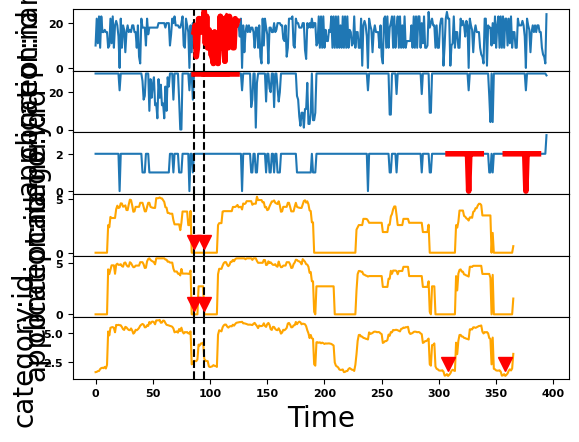

In [53]:
df = df[['concept:name:id', 'application:id', 'category:id']]
df['concept:name:id'] = df['concept:name:id'].astype(float)
df['application:id'] = df['application:id'].astype(float)
df['category:id'] = df['category:id'].astype(float)


m=30
mps, indices = stumpy.mstump(df, m)
motifs_idx = np.argmin(mps, axis=1)
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    if dim_name != 'T3':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()

### Run for artificial file

In [7]:
starting_row = 0
ending_row = len(df)-1
#Extract ids and rows
ids = df.loc[starting_row:ending_row,'id'].tolist()
rows = [i for i in range(len(df.loc[starting_row:ending_row,'id']))]

print(f"The motif should be at {indices}")
for size in [5,10,15,20]:
    window_size = size
    
    event_series = df.loc[starting_row:ending_row,'id'].values.astype(float)
    tm_matrix = stumpy.stump(event_series, window_size)
    
    motif_idx_tm = np.argsort(tm_matrix[:, 0])[0]
    nearest_neighbor_idx_tm = tm_matrix[motif_idx_tm, 1]

    print(f"The window size is {window_size}")
    print(f"The motif is located at index {motif_idx_tm} and it is an artificial motif: {any(abs(motif_idx_tm - element) <= size for element in indices)}")
    print(f"The nearest neighbor is located at index {nearest_neighbor_idx_tm}\n")

NameError: name 'indices' is not defined

## Plotting

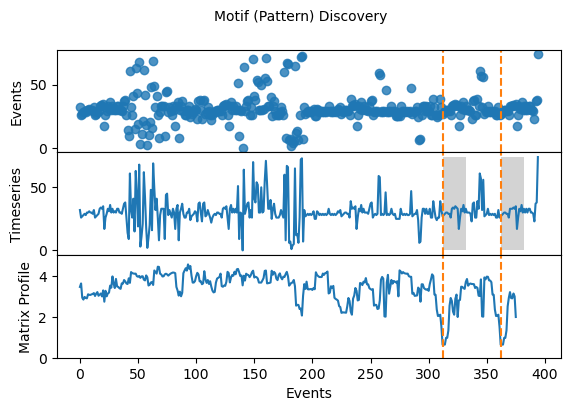

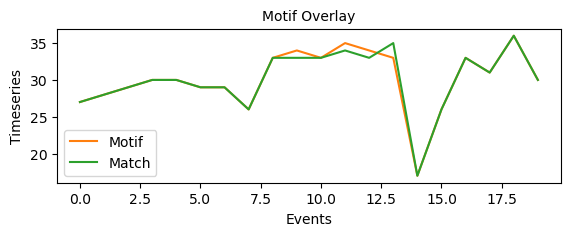

In [17]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6.5, 4))
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

#Plot Event data
axs[0].scatter(rows, ids, alpha=0.8)
axs[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs[1].plot(event_series)
axs[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
# Plot Matrix profiles
axs[2].set_xlabel('Events', fontsize ='10')
axs[2].set_ylabel('Matrix Profile', fontsize='10')
axs[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
axs[0].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[0].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
plt.show()

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
ax.plot(event_series[motif_idx_tm:motif_idx_tm+window_size], color='C1', label="Motif")
ax.plot(event_series[nearest_neighbor_idx_tm:nearest_neighbor_idx_tm+window_size], color='C2', label="Match")
plt.legend(loc="best",fontsize=10)
plt.show()

In [ ]:
# Print the desired rows
display(df.iloc[motif_idx_tm:min(motif_idx_tm + window_size, len(df))])
display(df.iloc[nearest_neighbor_idx_tm:min(nearest_neighbor_idx_tm + window_size, len(df))])

In [ ]:
# Events only plot
fig, ax = plt.subplots()
plt.title('Events', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.scatter(rows, ids, alpha=0.8)
plt.show()

In [ ]:
# Matrix Profil only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(event_series)
# Plot motif and nearest neighbor window
plt.show()

In [ ]:
#Timeseries plot only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(tm_matrix[:, 0])
plt.show()

## Find Top-K Motifs

From https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-Top-K-Motifs

Now that you’ve computed the matrix profile, mp, for your time series and identified the best global motif, you may be interested in discovering other motifs within your data. However, you’ll immediately learn that doing something like top_10_motifs_idx = np.argsort(mp[:, 0])[10] doesn’t actually get you what you want and that’s because this only returns the index locations that are likely going to be close to the global motif! Instead, after identifying the best motif (i.e., the matrix profile location with the smallest value), you first need to exclude the local area (i.e., an exclusion zone) surrounding the motif pair by setting their matrix profile values to np.inf before searching for the next motif. Then, you’ll need to repeat the “exclude-and-search” process for each subsequent motif. Luckily, STUMPY offers two additional functions, namely, stumpy.motifs and stumpy.match, that help simplify this process. While it is beyond the scope of this basic tutorial, we encourage you to check them out!



In [18]:
# ToDo: When a motif is discovered: Find all equal motifs in the data and extract (CTRL+X) them from the frame into a new frame
#    this new frame contains all variants of a motif and could be input to smartRPAs routine variant discovery
# Repeat until no motifs are found anymore

# min_neighbours: With min_neighbours one can select how often a process motif has to appear at least to be relevant => map this to number of executions
# max_matches
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=10)
top_motifs

(array([[5.24724032e-07, 6.34922207e-01, 2.47798510e+00, 3.22378741e+00,
         3.28167108e+00, 4.33413958e+00]]),
 array([[312, 362, 224,   7, 114, 211]], dtype=int64))

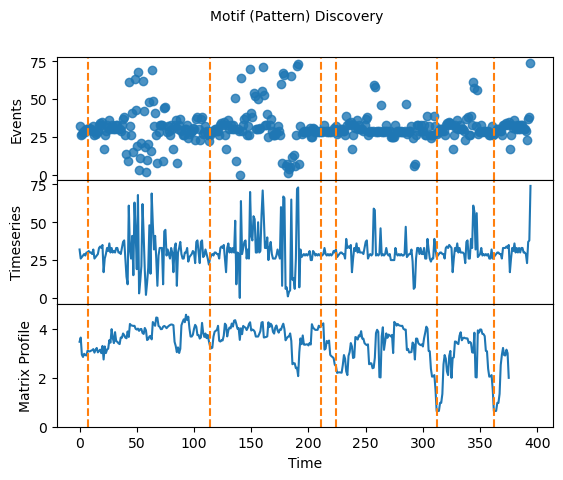

In [19]:
#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
# Plot Matrix profiles
axs2[2].set_xlabel('Time', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

plt.show()

In [ ]:
# Creates a dataframe that contains all paths from the top_motifs result 
allMotifsDF = pd.DataFrame() 
for i, element in enumerate(top_motifs[1][0]):
    motif_start = top_motifs[1][0][i]
    motifFrame = df.loc[motif_start:motif_start+window_size]
    allMotifsDF = pd.concat([allMotifsDF,motifFrame])
    print(motifFrame)

allMotifsDF

### Matching motives from most appearing motifs

Find all matches of a query `Q` in a time series `T`

The indices of subsequences whose distances to `Q` are less than or equal to `max_distance`, sorted by distance (lowest to highest). Around each occurrence an exclusion zone is applied before searching for the next.

In [ ]:
firstMotif = top_motifs[1][0][0]
foundMotif = event_series[firstMotif:firstMotif+window_size]
matchingPatterns = stumpy.match(Q=foundMotif,T=event_series,max_distance=0.5)
print(firstMotif)
print(matchingPatterns)
print(f"The amount of motifs found with matching patterns is {len(matchingPatterns)}")

## Identify process start and end

1. It is necessary to identify if it is the same process that was identified.
2. It is necessary to identify the start and end of the process:
    Where is the initial action? What is an initial action? What is the last action?

In [ ]:
# Set the index to the motif discovery by single motif discovery method
index_to_check = motif_idx_tm
end_of_window = index_to_check+window_size

try:
  start_forward_index, start_backward_index = find_closest_boundaries(df.copy(), index_to_check)
  end_forward_index, end_backward_index = find_closest_boundaries(df.copy(), end_of_window)

  print(f"The actual motif start is at index {index_to_check} and ends at {index_to_check+window_size} with window size being {window_size}.")
  print(f"Start Forward closest boundary index: {start_forward_index} and {abs(index_to_check-start_forward_index)} actions away.")
  print(f"Start Backward closest boundary index: {start_backward_index} and {abs(index_to_check-start_backward_index)} actions away.")  
  print(f"\nEnd Forward closest boundary index: {end_forward_index} and {abs(end_of_window-end_forward_index)} actions away.")
  print(f"End Backward closest boundary index: {end_backward_index} and {abs(end_of_window-end_backward_index)} actions away.")  

except ValueError as e:
  print(e)